In [246]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io, feature, filters,util
import glob
from ipywidgets import interact
from skimage.color import rgb2gray

In [247]:
img = io.imread('C:/Users/juanr/Documents/mediciones_ZEISS/bandas/Banda2scenes/Banda2scenes_m007.png')
#img = io.imread('C:/Users/juanr/Documents/mediciones microscopio metalografico/amarillo_11.tif')

In [248]:
img = rgb2gray(img)
img = util.invert(img)
pixels_to_microns = 0.586

In [249]:
from skimage.restoration import denoise_nl_means, estimate_sigma
# Estimate the average noise standard deviation across color channels.
sigma_est = np.mean(estimate_sigma(img, multichannel=False, average_sigmas=True))
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

Estimated Gaussian noise standard deviation = 0.005541120885189823


In [250]:
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=False)

# slow algorithm
denoise = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True,
                           **patch_kw)

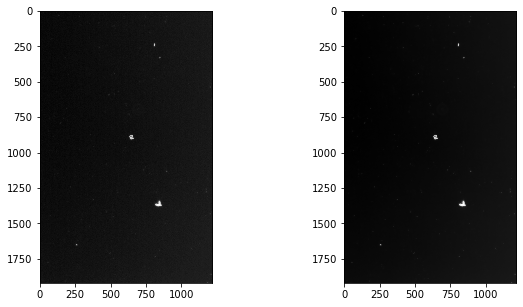

In [251]:
f,(ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.imshow(img,cmap='gray')
ax1.imshow(denoise,cmap='gray')

(array([1.60534e+05, 2.87617e+05, 3.05298e+05, 3.40757e+05, 3.50746e+05,
        3.04844e+05, 3.00160e+05, 1.84752e+05, 7.57980e+04, 1.66600e+04,
        2.02600e+03, 7.55000e+02, 4.65000e+02, 2.88000e+02, 2.33000e+02,
        1.96000e+02, 1.57000e+02, 1.38000e+02, 1.18000e+02, 1.08000e+02,
        8.20000e+01, 8.90000e+01, 7.20000e+01, 6.50000e+01, 5.70000e+01,
        3.50000e+01, 3.70000e+01, 4.70000e+01, 5.50000e+01, 3.60000e+01,
        4.70000e+01, 4.00000e+01, 2.90000e+01, 2.90000e+01, 4.20000e+01,
        2.40000e+01, 3.20000e+01, 4.10000e+01, 2.60000e+01, 3.40000e+01,
        2.30000e+01, 3.50000e+01, 2.50000e+01, 3.30000e+01, 2.40000e+01,
        2.20000e+01, 2.70000e+01, 2.50000e+01, 2.80000e+01, 2.60000e+01,
        1.80000e+01, 2.40000e+01, 2.60000e+01, 2.70000e+01, 2.00000e+01,
        2.90000e+01, 3.50000e+01, 2.70000e+01, 2.60000e+01, 2.60000e+01,
        3.20000e+01, 3.80000e+01, 3.00000e+01, 3.70000e+01, 3.60000e+01,
        4.00000e+01, 2.60000e+01, 4.00000e+01, 4.50

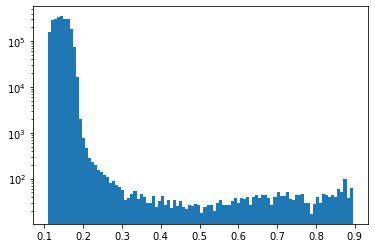

In [252]:
from skimage import img_as_ubyte
#denoised_img = img_as_ubyte(denoise)
plt.hist(denoise.flatten(),bins=100,log=True)

In [257]:
from scipy import ndimage
defects = denoise >= 0.8
labels, nlabels = ndimage.label(defects)

In [258]:
from skimage.measure import regionprops_table
props = regionprops_table(labels,denoise,properties=['label','area','centroid','equivalent_diameter','extent'])
props

{'label': array([1, 2, 3, 4]),
 'area': array([  9,   1,   3, 579]),
 'centroid-0': array([ 895,  898,  899, 1364]),
 'centroid-1': array([642, 646, 648, 833]),
 'equivalent_diameter': array([ 3.3851375 ,  1.12837917,  1.95441005, 27.15153212]),
 'extent': array([0.45      , 1.        , 1.        , 0.46693548])}

In [259]:
import pandas as pd  
data = pd.DataFrame(props)  
data['equivalent_diameter'] = data['equivalent_diameter']*pixels_to_microns
data['area'] = data['area']*pixels_to_microns*pixels_to_microns
data

,label,area,centroid-0,centroid-1,equivalent_diameter,extent
0,1,3.090564,895,642,1.983691,0.450000
1,2,0.343396,898,646,0.661230,1.000000
2,3,1.030188,899,648,1.145284,1.000000
3,4,198.826284,1364,833,15.910798,0.466935


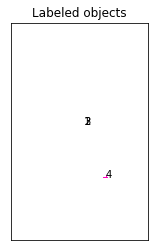

In [260]:
r, c = np.vstack(ndimage.center_of_mass(img, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)


fig = plt.figure()
ax = fig.add_subplot(111)    
ax.imshow(np.ma.masked_array(labels, ~defects), cmap=plt.cm.gist_rainbow) 
ax.set_title('Labeled objects')
plt.xticks([])
plt.yticks([])
for ri, ci, li in zip(r, c, range(1, nlabels+1)):
    ax.annotate(li, xy=(ci, ri), fontsize=10)
plt.show()

In [83]:
defects = (denoised_img <= 75)
semidefects = (denoised_img > 75) & (denoised_img < 150)
background = (denoised_img >= 150)

In [84]:
all_segments = np.zeros((denoised_img.shape[0],denoised_img.shape[1],3))
all_segments.shape

(1920, 1216, 3)

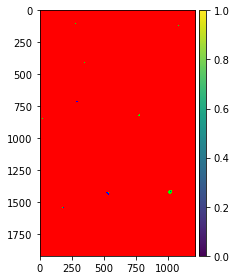

In [85]:
all_segments = np.zeros((denoised_img.shape[0],denoised_img.shape[1],3))


#colors

all_segments[defects] = (1,0,0)
all_segments[semidefects] = (0,1,0)
all_segments[background] = (0,0,1)

io.imshow(all_segments)

In [86]:
from scipy import ndimage as nd
defects_opened = nd.binary_opening(defects,np.ones((3,3)))
defects_closed = nd.binary_closing(defects_opened,np.ones((3,3)))

semidefects_opened = nd.binary_opening(semidefects,np.ones((3,3)))
semidefects_closed = nd.binary_closing(semidefects_opened,np.ones((3,3)))

background_opened = nd.binary_opening(background,np.ones((3,3)))
background_closed = nd.binary_closing(background_opened,np.ones((3,3)))

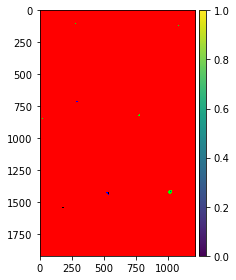

In [87]:
all_segments_cleaned = np.zeros((denoised_img.shape[0],denoised_img.shape[1],3))


#colors

all_segments_cleaned[defects_closed] = (1,0,0)
all_segments_cleaned[semidefects_closed] = (0,1,0)
all_segments_cleaned[background_closed] = (0,0,1)

io.imshow(all_segments_cleaned)

In [ ]:

from scipy import ndimage
from skimage.measure import regionprops
labels, no_objects = ndimage.label(defects)

In [ ]:
img.shape

In [ ]:
#reshaped_labels = np.array(labels).reshape(-1,1)
props = regionprops(labels)

In [ ]:
for prop in props:
    print('Label:{} diameter:{} microns'.format(prop.label,prop.equivalent_diameter*pixels_to_microns))

In [ ]:
img_defects = feature.blob_log(img, max_sigma = 30, num_sigma = 10, threshold = 0.1)

In [ ]:
len(img_defects)
print(img_defects)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.imshow(img,cmap='gray')


for b in img_defects:
    y, x, r = b[0],b[1],b[2]
    print(y,x,r)
    c = plt.Circle((y,x),r,color='#ff0000',lw = 2,fill = False)
    ax.add_patch(c)

plt.show()

In [ ]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


img = io.imread('C:/Users/juanr/Documents/mediciones_ZEISS/bandas/Banda2scenes/Banda2scenes_m005.png')
image_gray = rgb2gray(img)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.01)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.01)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.001)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()
